In [2]:
%load_ext blackcellmagic

In [3]:
import os
import cv2 

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TensorBoard,
)
from keras.datasets import mnist, fashion_mnist, cifar10, cifar100
from keras.layers import (
    Conv2D,
    Conv2DTranspose,
    Dense,
    Input,
    MaxPooling2D,
    UpSampling2D,
)
from keras.models import Model, Sequential, load_model
from keras.utils import to_categorical
from itertools import chain

from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [4]:
np.random.seed(42)

In [5]:
ANOMALY_STR ="anomaly"
NORMAL_STR = "normal"
USE_CASE ="bottle"
img_path = os.path.join("imgs",USE_CASE)
if not os.path.isdir(img_path):
    os.mkdir(img_path)
ckpt_path = os.path.join("ckpts",USE_CASE)
if not os.path.isdir(ckpt_path):
    os.mkdir(ckpt_path)
data_path = os.path.join("data","mvtec_anomaly_detection")
classes = list(filter(lambda d:os.path.isdir(os.path.join(data_path,d)),  os.listdir(data_path)))

# Preparing the data

In [6]:
object_categories = ["bottle","cable","capsule","metal_nut","pill","screw","tile","toothbrush","transistor","zipper"]

In [7]:
def read_image_file_names(dir_path):
    """Reads images per category for given directory path.
    Returns images as a generator object in intervall[0,1] rgb-format"""
    # data = np.empty(shape=(0,1,1,3),dtype=np.int8)
    cur_shape= None
    path_to_dir = os.path.join(os.getcwd(),dir_path)
    return [os.path.join(path_to_dir,p) for p in os.listdir(dir_path)]

In [8]:
def load_data():
    normal_path = os.path.join(data_path, USE_CASE, "train", "good")
    normal_train_data = read_image_file_names(normal_path)
    
    test_path = os.path.join(data_path,USE_CASE,"test")
    normal_test_data = read_image_file_names(os.path.join(test_path,"good"))
    anomaly_test_data = []
    for p in os.listdir(test_path):
        if p != "good":#    
            gen = read_image_file_names(os.path.join(test_path,p))
            anomaly_test_data +=  read_image_file_names(os.path.join(test_path,p))
    return normal_train_data, normal_test_data,normal_test_data, anomaly_test_data

In [9]:
X_normal_train, X_normal_validate, X_normal_test, X_anomaly_test = load_data()

In [10]:
def plot_mvtec(data):
    plt.imshow(data)

In [11]:
def hide_axis(subplt, x=True, y=True):
    if x:
        subplt.get_xaxis().set_visible(False)
    if y:
        subplt.get_yaxis().set_visible(False)

In [225]:
def plot_samples(row_one, row_two, f_plot, outfile=""):
    """Plot 8 sample images of the row_one and row_two"""
    plt.figure(figsize=(16, 4))
    # row_one
    n = min([8])
    for i in range(n):
        try:
            ax = plt.subplot(2, n, i+1)
            hide_axis(ax)
            f_plot(row_one[i]) # row_one
            ax = plt.subplot(2, n, n+i+1)
        except IndexError:
            pass
        try:
            f_plot(row_two[i]) # row_two
            hide_axis(ax)
        except IndexError:
            pass
    if outfile!="":
        plt.savefig(outfile)

In [13]:
path = os.path.join(img_path,"{}-{}.png".format(NORMAL_STR,ANOMALY_STR))
plot_samples(yield_images(X_normal_train,8,n=8,input_only=True), yield_images(X_normal_train,8,n=8,input_only=True), plot_mvtec,path)


# Extracting features with an auto encoder (ae)

In [14]:
def get_codec_from_ae(autoencoder):
    encoder_layer = autoencoder.get_layer("encoder")
    # this model maps an input to its encoded representation; Big image to small rep
    encoder = Model(
        inputs=autoencoder.input, outputs=encoder_layer.output)

    # create a placeholder for an encoded (ENCODING_DIM-dimensional) input
    encoded_input = Input(shape=encoder_layer.output_shape[1:])

    # getting the middle of the autoencoder
    start = (len(autoencoder.layers))//2
    decoder = autoencoder.layers[-start](encoded_input)
    # stacking the decoder layers
    for i in range(start-1, 0, -1):
        decoder = autoencoder.layers[-i](decoder)

    # create the decoder model; "<": encoded(small) representation to big image
    decoder = Model(encoded_input, decoder)
    return encoder, decoder

In [15]:
def build_conv_ae(
    filters, input_shape=(28, 28, 1), kernel=(3, 3), pool_size=(2, 2), color="gray"
):
    # STRETCH GOAL: variable number of layers and pool_size
    pool_size = (2, 2)
    kernel = (3, 3)
    if len(filters) != 4:
        raise ValueError("Four Filters must be given. Sorry.")
    # this is our input placeholder
    input_img = Input(shape=input_shape)
    # layer between input and middle layer
    i = 0
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(input_img)
    encode = MaxPooling2D(pool_size, padding="same")(encode)
    i += 1
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encode)
    #encode = MaxPooling2D(pool_size, padding="same")(encode)
    i += 1
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encode)
    #encode = MaxPooling2D(pool_size, padding="same")(encode)
    i += 1
    encode = Conv2D(filters[i], kernel, activation="relu", padding="same")(encode)

    # "encoded" is the encoded representation of the input, middle layer of the aue
    encoded = MaxPooling2D(pool_size, padding="same", name="encoder")(encode)

    # layer between middle and output layer
    decode = Conv2DTranspose(filters[i], kernel, activation="relu", padding="same")(encoded)
    #decode = UpSampling2D(pool_size)(decode)
    i -= 1
    decode = Conv2DTranspose(filters[i], kernel, activation="relu", padding="same")(decode)
    #decode = UpSampling2D(pool_size)(decode)
    i -= 1
    decode = Conv2DTranspose(filters[i], kernel, activation="relu", padding="same")(decode)
    decode = UpSampling2D(pool_size)(decode)
    i -= 1
    decode = Conv2D(filters[i], kernel, activation="relu",padding="same")(decode)
    decode = UpSampling2D(pool_size)(decode)
    decoded = Conv2D(
        1 if color == "gray" else 3, kernel, activation="sigmoid", padding="same"
    )(decode)

    # this model maps an input to its reconstruction
    autoencoder = Model(inputs=input_img, outputs=decoded)

    encoder, decoder = get_codec_from_ae(autoencoder)

    # build (aka "compile") the model
    autoencoder.compile(optimizer="adadelta", loss="mse")
    return autoencoder, encoder, decoder

## Training the feature extractor auto encoder

In [66]:
def yield_images(file_paths, batch_size,single_batch=False, input_only=False):
        while True:
            rands = np.random.random_integers(0,len(file_paths)-1,batch_size)
            #print(rands)
            imgs = np.zeros((batch_size,900,900,3))
            for j,r in enumerate(rands):
                # print(r,len(file_paths))
                fp = file_paths[r]
                if os.path.isfile(fp):
                    img = cv2.imread(fp)   # reads an image in the BGR format
                    imgs[j] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # BGR -> RGB
            
                    
            if not input_only:
                yield imgs / 255, imgs/255
            else: 
                yield imgs /255
            if single_batch:
                break

In [33]:
ckpt_loc = os.path.join(ckpt_path,"feature-extractor-ae.hdf5")

if os.path.isfile(ckpt_loc):
    print("Loading Autoencoder for %s feature extraction from directory %s..." % (USE_CASE,ckpt_loc))
    ae = load_model(ckpt_loc)
    encoder, decoder = get_codec_from_ae(ae)
    ae.summary()    
else:
    print("Training Autoencoder for %s feature extraction..." % USE_CASE)
    ae, encoder, decoder = build_conv_ae(input_shape=(900,900,3),filters=[16,12,8,2],color="not-gray")
    earlyStopping = EarlyStopping(
        monitor="val_loss", patience=10, verbose=1, mode="min", min_delta=0.0005
    )
    mcp_save = ModelCheckpoint(
        ckpt_loc, save_best_only=True, verbose=1, monitor="val_loss", mode="min"
    )
    reduce_lr_loss = ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=3, verbose=1, mode="min"
    )
    # ae.summary()   
    ae.fit_generator(
        generator=yield_images(X_normal_train,4),# needs to produce data infinitely
        epochs=128,
        steps_per_epoch=len(X_normal_train),
        shuffle=True,
        validation_data=yield_images(X_normal_validate,1),
        validation_steps=len(X_normal_validate),
        callbacks=[earlyStopping,mcp_save,reduce_lr_loss]
    )

Loading Autoencoder for bottle feature extraction from directory ckpts\bottle\feature-extractor-ae.hdf5...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 900, 900, 3)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 900, 900, 16)      448       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 450, 450, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 450, 450, 12)      1740      
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 450, 450, 8)       872       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 450, 450, 2)       146       
___________________________________

TODO fix parametrised ae building

## Evaluating the feature extractor

In [34]:
def evaluate_ae(ae, X_train, X_test):
    eval_train = ae.evaluate_generator(yield_images(X_train,1),steps=len(X_train))
    eval_test = ae.evaluate_generator(yield_images(X_test,1),steps=len(X_test))
    return eval_train,  eval_test

In [35]:
eval_train, eval_test = evaluate_ae(
    ae, X_normal_train, X_normal_test
)
print(eval_train, eval_test)

C:\Users\danie\.conda\envs\tf-env\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 208 + 1) instead
  after removing the cwd from sys.path.
C:\Users\danie\.conda\envs\tf-env\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 19 + 1) instead
  after removing the cwd from sys.path.


0.0007384066204273066 0.0008023310278076678


In [88]:
encoded_normal_imgs_train = encoder.predict_generator(
    yield_images(X_normal_train, 1, input_only=True), steps=len(X_normal_train)
)  # used later for One Class Classification
encoded_normal_imgs_test = encoder.predict_generator(
    yield_images(X_normal_test, 1, input_only=True), steps=len(X_normal_test)
)
decoded_normal_imgs = decoder.predict(encoded_normal_imgs_test)

C:\Users\danie\.conda\envs\tf-env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 208 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\danie\.conda\envs\tf-env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 19 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


C:\Users\danie\.conda\envs\tf-env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 19 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


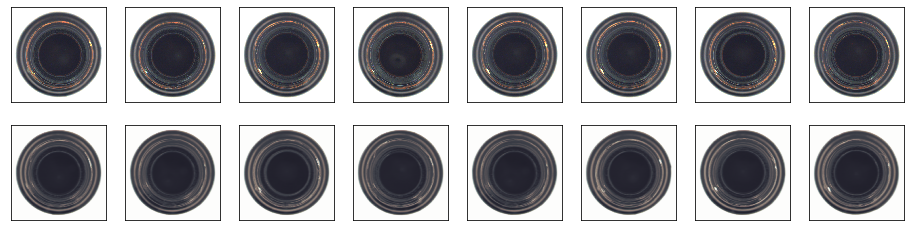

In [89]:
plot_samples(
    next(yield_images(X_normal_test, 8, single_batch=True, input_only=True)),
    decoded_normal_imgs,
    plot_mvtec,
    os.path.join(img_path, "rec-{}.png".format(NORMAL_STR)),
)

In [212]:
encoded_anomaly_imgs = encoder.predict_generator(
    yield_images(X_anomaly_test, 1, input_only=True), steps=len(X_anomaly_test)
)  # used later for One Class Classification
print(encoded_anomaly_imgs.shape)

# decode batch wise:
batch_size_decode = 8

epochs = np.arange(0, len(encoded_anomaly_imgs), batch_size_decode)
decoded_anomaly_imgs = np.zeros((0, 900, 900, 3))

for i in range(len(epochs)):
    # print(epochs[i], epochs[i + 1] if i+1<len(epochs) else None)
    decoded_anomaly_imgs = np.concatenate(
        (decoded_anomaly_imgs,
        decoder.predict(encoded_anomaly_imgs[epochs[i] : epochs[i + 1] if i+1<len(epochs) else None]))
    )
len(decoded_anomaly_imgs)

C:\Users\danie\.conda\envs\tf-env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 62 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


(63, 225, 225, 2)


63

C:\Users\danie\.conda\envs\tf-env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 62 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


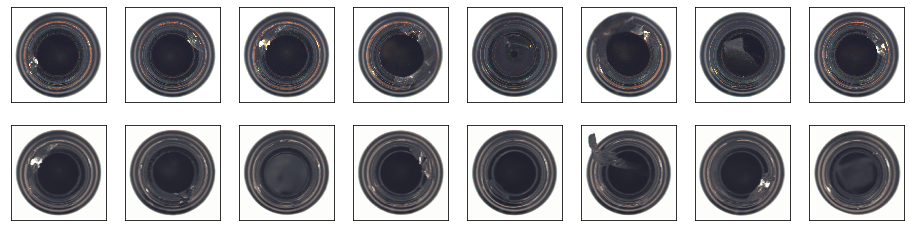

In [213]:
plot_samples(
    next(yield_images(X_anomaly_test, 8, single_batch=True, input_only=True)),
    decoded_anomaly_imgs,
    plot_mvtec,
    os.path.join(img_path, "rec-{}.png".format(ANOMALY_STR)),
)

# Anomaly detection
## Loss based
### Computing the reconstruction loss for anomalies and normalities

In [214]:
def loss_per_img(img,rec_img):
    return np.sum(np.power(rec_img - img,2))

In [215]:
normal_losses = np.array([loss_per_img(i,ri) for i,ri in zip(next(yield_images(X_normal_test,len(decoded_normal_imgs),single_batch=True, input_only=True)),decoded_normal_imgs)])
anomaly_losses = np.array([loss_per_img(i, ri) for i, ri in zip(next(yield_images(X_anomaly_test,len(decoded_anomaly_imgs),single_batch=True, input_only=True)), decoded_anomaly_imgs)])
normal_losses.mean(), anomaly_losses.mean()

C:\Users\danie\.conda\envs\tf-env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 19 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\danie\.conda\envs\tf-env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 62 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


(9287.105058158962, 17739.62085734676)

In [216]:
def plot_hist(values, bins=50, relative=False, color="r"):
    t = np.linspace(values.min(), values.max(), bins)
    denominator = len(values) if relative else 1
    hist = np.histogram(values, bins)
    plt.plot(t, hist[0]/denominator, color)

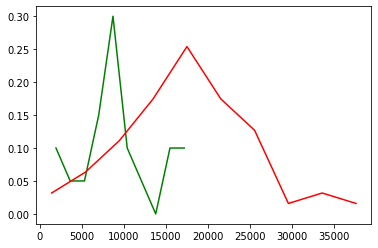

In [217]:
bins = 10
# loss distribution over the normal dataset
plot_hist(normal_losses,relative=True,color="g",bins=bins)
# loss distribution over the anomaly dataset 
plot_hist(anomaly_losses,relative=True,color="r",bins=bins)
plt.show()

### Evaluating the loss based approach

C:\Users\danie\.conda\envs\tf-env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 19 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\danie\.conda\envs\tf-env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 62 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


threshold:0.500,dn:0.500000 + ua:0.095238 = 0.595238
threshold:0.550,dn:0.450000 + ua:0.095238 = 0.545238
threshold:0.600,dn:0.400000 + ua:0.095238 = 0.495238
threshold:0.650,dn:0.350000 + ua:0.111111 = 0.461111
threshold:0.700,dn:0.300000 + ua:0.111111 = 0.411111
threshold:0.750,dn:0.250000 + ua:0.206349 = 0.456349
threshold:0.800,dn:0.200000 + ua:0.317460 = 0.517460
threshold:0.850,dn:0.150000 + ua:0.317460 = 0.467460
threshold:0.900,dn:0.100000 + ua:0.380952 = 0.480952


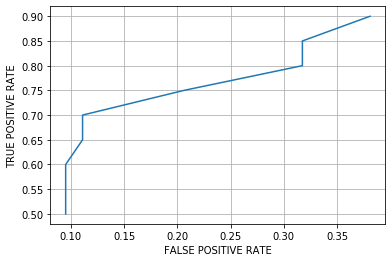

(0.7000000000000002, 10544.981656869208)

In [221]:
# x:= "false detected anomalies in %"
# y:= "correct detected normal data points in %"
FPs = FNs = []
prec = 20  # precision for getting the best threshold value
step_size = 1.0 / prec
TPs = np.arange(0.5, 1-step_size, step_size)

for i in TPs: 
    # loss value for detection of i*100 percent normal data points
    loss_boundary = np.sort(normal_losses)[int(len(normal_losses) * i)] 

    detected_normals = next(yield_images(X_normal_test,batch_size=len(X_normal_test), single_batch=True, input_only=True))[normal_losses >= loss_boundary]
    undetected_anomalies = next(yield_images(X_anomaly_test,batch_size=len(X_anomaly_test), single_batch=True, input_only=True))[anomaly_losses < loss_boundary]

    FP_rate = len(undetected_anomalies) / len(
        anomaly_losses
    )  # ratio between not detected loss values for anomalies
    FN_rate = len(detected_normals) / len(
        normal_losses
    )  # ratio between not detected loss values for anomalies

    FPs = np.append(FPs, FP_rate)  # not detected anomalies
    FNs = np.append(FNs, FN_rate)  # as anomalies detected normalities
    if FP_rate + FN_rate <= min(FNs + FPs): # less or equal since we want the biggest TP_rate (i)
        loss_threshold = i
        best_boundary = loss_boundary
        
    # print every 1/10 threshold step
    if (int(i * prec)) % (prec//20) == 0:
        print(
            "threshold:%.3f,dn:%f + ua:%f = %f"
            % (i, FN_rate, FP_rate, FN_rate + FP_rate)
        )
    # minimum value for FN_rate + FP_rate (least relative amount of falsely detected)

plt.plot(FPs,TPs)
plt.grid()
plt.xlabel("FALSE POSITIVE RATE")
plt.ylabel("TRUE POSITIVE RATE")
plt.show()
loss_threshold, best_boundary

In [222]:
detected_normals =next(yield_images(X_normal_test,batch_size=len(X_normal_test), single_batch=True, input_only=True))[normal_losses >= best_boundary] # values on the boundary are seen as anomalies
undetected_anomalies =  next(yield_images(X_anomaly_test,batch_size=len(X_anomaly_test), single_batch=True, input_only=True))[anomaly_losses < best_boundary]
len(detected_normals), len(undetected_anomalies)

C:\Users\danie\.conda\envs\tf-env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 19 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\danie\.conda\envs\tf-env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 62 + 1) instead
  This is separate from the ipykernel package so we can avoid doing imports until


(6, 7)

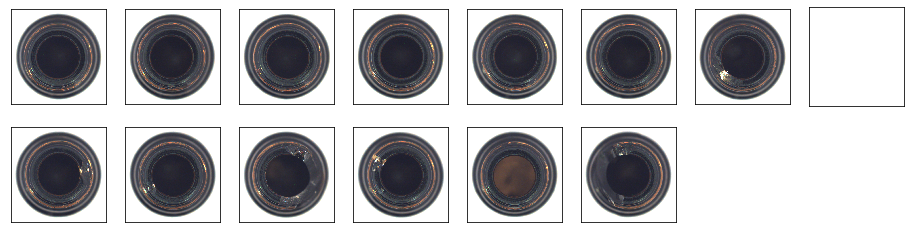

In [226]:
plot_samples(detected_normals,undetected_anomalies,plot_mvtec, os.path.join(img_path,"wrong-{}.png".format(USE_CASE)))

### Predicting with the reconstruction loss approach

In [229]:
def is_anomaly(X,boundary):
    rec_img = ae.predict(X)
    return loss_per_img(rec_img,X) > boundary

In [230]:
this_should_be_false = is_anomaly(X_normal_validate[0], best_boundary)
this_should_be_true = is_anomaly(X_anomaly_validate[0], best_boundary)
this_should_be_false, this_should_be_true

AttributeError: 'str' object has no attribute 'ndim'

## One Class SVM approach

In [ ]:
from sklearn import svm
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score,accuracy_score

In [ ]:
encoded_normal_imgs_train = encoded_normal_imgs_train.reshape(
            -1, np.prod(encoded_normal_imgs_train.shape[1:])
        )
encoded_normal_imgs_test = encoded_normal_imgs_test.reshape(
            -1, np.prod(encoded_normal_imgs_test.shape[1:])
        )
encoded_anomaly_imgs = encoded_anomaly_imgs.reshape(-1, np.prod(encoded_anomaly_imgs.shape[1:]))
best_metrics =0
for i in np.arange(0.1, 1, 0.1):
    clf = svm.OneClassSVM(gamma="auto", nu=i)
    clf.fit(encoded_normal_imgs_train)
    
    score_normal = clf.predict(encoded_normal_imgs_test)
    bins = 2
    # hist_normal = np.histogram(score_normal, bins)
    # t = np.linspace(score_normal.min(), score_normal.max(), bins)
    # plt.bar(t, hist_normal[0], width=0.5, color="g")
    # plt.show()

    score_anomaly = clf.predict(encoded_anomaly_imgs)

    # hist_anomaly = np.histogram(score_anomaly, bins)
    # t = np.linspace(score_anomaly.min(), score_anomaly.max(), bins)
    # plt.bar(t, hist_anomaly[0], width=0.5, color="r")
    # plt.show()


    TP = len(score_normal[score_normal == 1])
    FN = len(score_normal[score_normal == -1])

    TN = len(score_anomaly[score_anomaly == -1])
    FP = len(score_anomaly[score_anomaly == 1])
    accuracy = (TP + TN) / (len(score_normal) + len(score_anomaly))
    precision = TP / (TP + FN)
    recall = TP / (TP + FP)
    if (accuracy+precision+recall)/3 > best_metrics:
        best_nu = i
        best_metrics = (accuracy+precision+recall)/3
        oc_svm = clf
    print("%.2f" % i, accuracy, precision, recall)
best_nu,best_metrics


In [ ]:
def is_anomaly_svm(X,oc_svm):
    X = X.reshape((1,X.shape[0]))
    prediction = oc_svm.predict(X)[0]
    return prediction == -1

In [ ]:
this_should_be_false_svm = is_anomaly_svm(encoded_normal_imgs_train[0], oc_svm)
this_should_be_true_svm = is_anomaly_svm(encoded_anomaly_imgs[0], oc_svm)
this_should_be_false_svm, this_should_be_true_svm

# TODO: Encoded feature analysis with our friend CF Gauss

In [ ]:
flat_shape = np.prod(encoded_normal_imgs_train.shape[1:], dtype=np.int64)
encoded_normal_imgs_train = encoded_normal_imgs_train.reshape(
    len(encoded_normal_imgs_train), flat_shape
)
encoded_normal_imgs_test = encoded_normal_imgs_test.reshape(
    len(encoded_normal_imgs_test), flat_shape
)

In [ ]:
def gauss(x_i, my_i, sigma_i2):
    # gaussian distribution for one feature
    if sigma_i2 == 0:
        return 1 if x_i == my_i else 0
    return np.array(
        (1 / np.sqrt(2 * np.pi * sigma_i2))
        * np.exp(-(x_i - my_i) ** 2 / (2 * sigma_i2))
    )

In [ ]:
def my(X):
    return np.array([(1 / len(x)) * np.sum(x) for x in X.T])

In [ ]:
def sigma2(X, my):
    # computes sigma squared for each feature
    m = len(X)  # number of data points
    return np.array([(1/m)*np.sum((X[:, i] - my[i]) ** 2) for i in range(len(my))])

In [ ]:
def p(X,my,sigma2):
    return np.array([np.prod([gauss(x[i], my[i], sigma2[i])
               for i in range(len(x))]) for x in X])

In [ ]:
X= encoded_normal_imgs_test
m = len(X)
number_of_features = len(X[0])
my = np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 = np.array(
    [np.sum((X[:, i] - my[i]) ** 2) / m for i in range(number_of_features)]
)

p_all = p(X, my, sigma_2)


In [ ]:
plt.figure(figsize=(20, 20))
for i in range(len(my)-1):
    # plots distribution of i-th feature
    # display original
    bins = 20
    hist = np.histogram(X[:, i], bins=bins)
    ax = plt.subplot(4, 6, i + 1)
    r = np.linspace(start=min(X[:, i]), stop=max(X[:, i]), num=bins)
    plt.plot(r, hist[0]/len(X[:,i]))

In [ ]:
X= encoded_anomaly_imgs
m = len(X)
number_of_features = len(X[0])
my = np.array([(1 / len(x)) * np.sum(x) for x in X.T])
sigma_2 = np.array(
    [np.sum((X[:, i] - my[i]) ** 2) / m for i in range(number_of_features)]
)

p_all = p(X, my, sigma_2)
plt.figure(figsize=(20, 20))
for i in range(len(my)-1):
    # plots distribution of i-th feature
    # display original
    bins = 20
    hist = np.histogram(X[:, i], bins=bins)
    ax = plt.subplot(4, 6, i + 1)
    r = np.linspace(start=min(X[:, i]), stop=max(X[:, i]), num=bins)
    plt.plot(r, hist[0]/len(X[:,i]))